In [1]:
import gym
import torch
from a3_gym_env.envs.pendulum import CustomPendulumEnv
import numpy as np
import math
from torch import optim

from torch.distributions import Normal

from torch.optim import Adam
from torch.distributions.multivariate_normal import MultivariateNormal
from Modules import PolicyNetwork, ExperienceReplayBuffer, CriticNetwork

# [DONE] Task 1: Start by implementing an environment interaction loop. You may refer to homework 1 for inspiration.
# [ ] Task 2: Create and test an experience replay buffer with a random policy, which is the Gaussian distribution with arbitrary (randomly initialized) weights of the policy feed-forward network,receiving state, s, and returning the mean, mu(s) and the log_std, log_stg(s) (natural logarithm of the standard deviation) of actions.  As mentioned above, you can use a state-independent standard variance.
# [ ] Task 3: Make an episode reward processing function to turn one-step rewards into discounted rewards-to-go: R(s_1) = sum_{t=1} gamma^{t-1} r_t, which is the discounted reward, starting from the state, s_1.
# [ ] Task 4: Start the model by implementing a vanilla policy gradient agent, where the gradient ascent stepsare done with the average of the gradient of log-likelihood over a trajectory weight by rewards-to-go   from each state. Try different step sizes in the gradient ascent.
# [ ] Task 5: Pendulum is a continuous action space environment. Check out the example in `Modules.py` for torch implementation of the Gaussian module.  (if you work in Julia, speak with me regarding the pendulum dynamics in Julia, and Flux for DNNs.)
# [ ] Task 6: Add a feed-forward network for the critic, accepting the state, s=[sin(angle), cos(angle), angular velocity], and returning a scalar for the value of the state, s.
# [ ] Task 7: Implement the generalized advantage, see Eq11-12 in the PPO paper, to be used instead of rewards-to-go.
# [ ] Task 8: Implement the surrogate objective for the policy gradient, see Eq7, without and without clipping.
# [ ] Task 9: Implement the total loss, see Eq9 in the PPO.
# [ ] Task 10: Combine all together to Algorithm 1 in the PPO paper. (In your basic implementation, you can collect data with a single actor, N=1)
# [ ] Task 11: You should see progress with default hyperparameters, but you can try tuning those to see how it will improve your results.


In [2]:

def interaction_loop():
    env = gym.make("Pendulum-v1-custom")
    # sample hyperparameters
    '''batch_size = 1000
    epochs = 30
    learning_rate = 1e-2'''

    max_step = 10
    obs = env.reset()
    print(type(obs))
    for _ in range(max_step):
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        img = env.render()
        if done:
            obs = env.reset()
    env.close()

    
# task 2 * Create and test an experience replay buffer with a random policy, which is the 
#Gaussian distribution with arbitrary (randomly initialized) weights of the policy feed-forward network,
#receiving state, s, and returning the mean, mu(s) and the log_std, log_stg(s) 
#(natural logarithm of the standard deviation) of actions.  As mentioned above, you can use 
#a state-independent standard variance.
def test_experience_relay_buffer():
    env = gym.make("Pendulum-v1-custom")
    batch_size = 1000
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

    max_step = 1000
    
    policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.shape[0])
    
    memory = ExperienceReplayBuffer(batch_size)

    for _ in range(max_step):
        action = env.action_space.sample()

        obs, reward, done, info = env.step(action)
        next_state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        memory.push(state, action, next_state, reward)

        res = policy(state)
        
        # print(res)
        state = next_state
        img = env.render()
        if done:
            obs = env.reset()
    
    env.close()


# Sample an action from Normal distribution
def choose_action(policy, state):  
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    act_prob, v = policy(state)
    v = torch.exp(v)
    pd = Normal(act_prob, torch.sqrt(v)) # get normal distirbution
    action = pd.sample() # sample from it
    log_prob = pd.log_prob(action)
    return action, log_prob

# task 3 * Make an episode reward processing function to turn one-step rewards into discounted rewards-to-go:
#R(s_1) = sum_{t=1} gamma^{t-1} r_t, which is the discounted reward, starting from the state, s_1.   
def dis_r_to_go(r_batch, gamma):
    r_togo = np.zeros(len(r_batch))
    R=0
    for i in reversed(range(len(r_batch))):
        R = r_batch[i] + (gamma**i)*R
        r_togo[i] = R
    
    return r_togo
 
    
# task 4 Start the model by implementing a vanilla policy gradient agent, where the gradient ascent steps
#are done with the average of the gradient of log-likelihood over a trajectory weight by rewards-to-go   
#from each state. Try different step sizes in the gradient ascent.
def run_trajectory(env_name, policy, gamma, learning_rate):
    env = gym.make(env_name)
    batch_size=1000
     
    obs_batch = [] # stores states
    traj_r_batch = [] # all rewards in a trajectory
    act_batch = [] # action batch
    r_tg_batch=[] # reward to go batch
    log_batch=[] # log prob batch
    loss_batch=[] # loss batch
    
    count = 0
    
    traj_r = []
    obs = env.reset()
    done = False 
    while (count<batch_size): # time steps
        action, log_prob = choose_action(policy, obs)
        act_batch.append(action)
        log_batch.append(log_prob)
        obs_batch.append(obs)
            
        obs, reward, done, info = env.step(action)
        traj_r.append(reward)
        if done:
            break
        count+=1
        
            
    traj_r_tg = dis_r_to_go(traj_r, 0.99) # r to go
                
    r_tg_batch.append(traj_r_tg) 
        
    '''log_batch_tensor = torch.stack(log_batch)
        r_tg_batch_tensor = torch.cat(r_tg_batch)
        
        loss = -(log_batch_tensor * r_tg_batch_tensor).mean() # gradient ascent
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()'''
        
    obs_batch = torch.tensor(obs_batch, dtype=torch.float, requires_grad=True)
    act_batch = torch.tensor(act_batch, dtype=torch.float,requires_grad=True)
    r_tg_batch = torch.tensor(r_tg_batch, dtype=torch.float,requires_grad=True)
    log_batch = torch.tensor(log_batch, dtype=torch.float,requires_grad=True)

    #print(loss.item())   
    return obs_batch, act_batch, r_tg_batch, log_batch

    
def test_vanilla_gradient_ascent(): 
    """
    * Start the model by implementing a vanilla policy gradient agent, where the gradient ascent steps
    are done with the average of the gradient of log-likelihood over a trajectory weight by rewards-to-go   
    from each state. Try different step sizes in the gradient ascent.  
    """
    env = gym.make("Pendulum-v1-custom")
    env.reset()
    loss_batch = []
    epoch = 100
    learning_rate = 0.01

    batch_size = 1000
    # Policy Network
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.shape[0]
    policy = PolicyNetwork(input_size, output_size)#.to(device)
    optimizer =  Adam(policy.parameters(), lr=learning_rate)

    for i in range(epoch):
        batch_obs, batch_acts, batch_rtgs,batch_log_probs  = run_trajectory("Pendulum-v1-custom", policy, 0.95, 0.01)
        #print(batch_rtgs.shape)
        #print(batch_log_probs.shape)
        loss = -(batch_rtgs * batch_log_probs).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_batch.append(loss)
        
        
    env.close()
    return loss_batch, batch_rtgs, batch_obs, batch_log_probs, policy



'''Task 5: * Pendulum is a continuous action space environment. 
Check out the example in `Modules.py` for torch implementation of the Gaussian module.  
(if you work in Julia, speak with me regarding the pendulum dynamics in Julia, and Flux for DNNs.)'''
    

'''Task 6: Add a feed-forward network for the critic, accepting the state, s=[sin(angle), cos(angle), angular velocity], 
and returning a scalar for the value of the state, s.'''
def CriticNet(state):
    #input_size = state.shape
    input_size=3
    output_size = 1
    critic = CriticNetwork(input_size, output_size)
    scalar = critic(torch.FloatTensor(state))
    #scalar = critic(state)
    return scalar.item()

# calculate values of state of actor network
def calc_value(state_batch):
    l = state_batch.size(dim=0)
    value_batch = np.zeros(l)
    my_scalar = 0
    for i in range(l):
        my_scalar = CriticNet(state_batch[i])
        value_batch[i] = my_scalar
        #print(value_batch[i])
    value_batch = torch.tensor(value_batch, dtype=torch.float)
    return value_batch
    
    
'''Task 7 Implement the generalized advantage, see Eq11-12 in the PPO paper, to be used instead of rewards-to-go.'''
# advantage estimator
def generalized_advantage(r_batch, value, gamma=0.99, lamd=0.95):
    gae = 0
    b_size = r_batch.size(dim=1)
    adv = torch.zeros(b_size, dtype=torch.float) # batch for generalized advantage
    next_value = 0

    for t in reversed(range(b_size)): # 
        b_error = r_batch[0][t] + gamma * next_value - value[t]
        gae = b_error + gae * gamma * lamd
        next_value = value[t]
        adv[t] = gae
        
        #print(gae)
    

    return adv



'''Task 8  Implement the surrogate objective for the policy gradient, see Eq7, with and without clipping. '''
def surrogate_obj(log_batch, A_head, epsilon):
    
    cpi = torch.zeros(log_batch.size(dim=0))
    sur_obj = torch.zeros(log_batch.size(dim=0))
    for i in reversed(range(log_batch.size(dim=0))):
        if (i>0):
            cur_policy = log_batch[i]
            ratio = cur_policy/log_batch[i-1]
            cpi[i] = ratio * A_head[i] # conservative policy iteration
            clip_ratio = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) # limit the clamp range betwween 1-epislon and 1+epislon
            sur_obj[i] = torch.min(cpi[i], (clip_ratio*A_head[i]))
    
    cpi = torch.tensor(cpi, dtype=torch.float)
    sur_obj = torch.tensor(sur_obj, dtype=torch.float)
    return sur_obj, cpi


'''Task 9 Implement the total loss, see Eq9 in the PPO. '''
def PPO_eq9(policy, obs_batch, act_batch, adv_batch, ret_batch, epsilon):
    
    #action, log_prob = choose_action(policy, obs)
    
    
     
    
    return 0


'''Task 10 Combine all together to Algorithm 1 in the PPO paper. 
(In your basic implementation, you can collect data with a single actor, N=1)'''
def algorithm_1():
    #for iteration in range():
     #   for actor in range():
            
    
    return 0


if __name__ == "__main__":
    mybatch=[1,3,5,7,9]
    #interaction_loop()
    #test_experience_relay_buffer()
    
    pgloss, pgres, state_batch, pglog_batch, policy = test_vanilla_gradient_ascent()
    #criticNet(s_batch)
    
    
    
    #res=dis_r_to_go(mybatch, 0.9)
    
    
    
    

/Users/dazhouliu/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/Users/dazhouliu/Desktop/CMPE260/cmpe260-hws-main/hw3/a3_gym_env/envs/pendulum.py:123: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  self.state = np.array([newth, newthdot])
/Users/dazhouliu/Desktop/CMPE260/cmpe260-hws-main/hw3/a3_gym_env/envs/pendu

In [3]:
for i in range(len(pgloss)):
    pgloss[i]=(pgloss[i].detach().numpy())


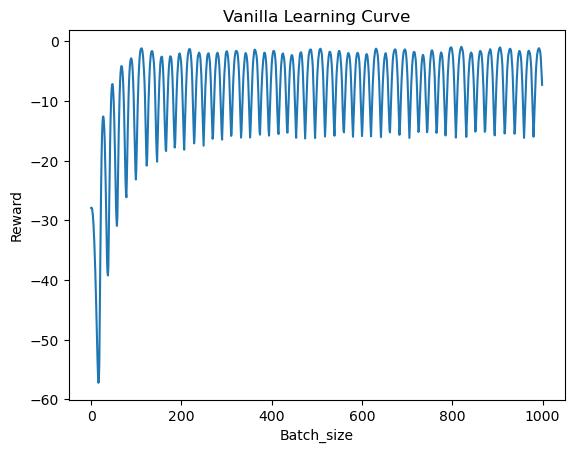

In [4]:
import matplotlib.pyplot as plt


plt.plot((pgres.detach().numpy()).squeeze())
plt.xlabel('Batch_size')
plt.ylabel('Reward')
plt.title('Vanilla Learning Curve')
plt.show()

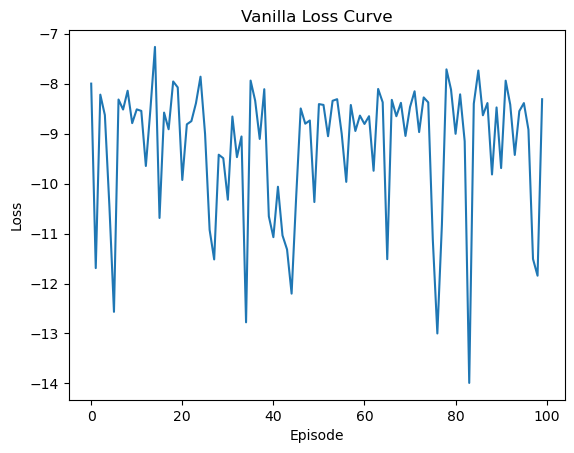

In [5]:
import matplotlib.pyplot as plt


plt.plot(pgloss)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Vanilla Loss Curve')
plt.show()

In [6]:
value=calc_value(state_batch)

In [7]:
adv = generalized_advantage(pgres, value, gamma=0.99, lamd=0.95)

In [8]:
(adv).shape

torch.Size([1000])

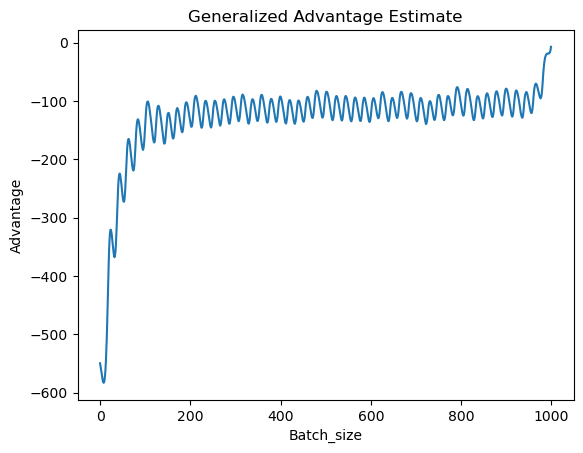

In [9]:
plt.plot((adv.detach().numpy()))
plt.xlabel('Batch_size')
plt.ylabel('Advantage')
plt.title('Generalized Advantage Estimate')
plt.show()

In [10]:
c1, c2=surrogate_obj(pglog_batch, adv, 0.2)

/var/folders/q8/yg5ykqgx4xxbmzglr25_439r0000gn/T/ipykernel_8516/3721742658.py:244: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cpi = torch.tensor(cpi, dtype=torch.float)
/var/folders/q8/yg5ykqgx4xxbmzglr25_439r0000gn/T/ipykernel_8516/3721742658.py:245: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sur_obj = torch.tensor(sur_obj, dtype=torch.float)


In [11]:
torch.equal(c1, c2)

False

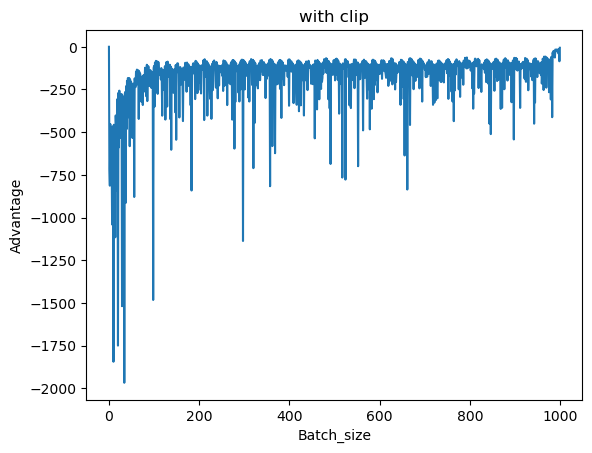

In [12]:
plt.plot((c1.detach().numpy()))
plt.xlabel('Batch_size')
plt.ylabel('Advantage')
plt.title('with clip')
plt.show()

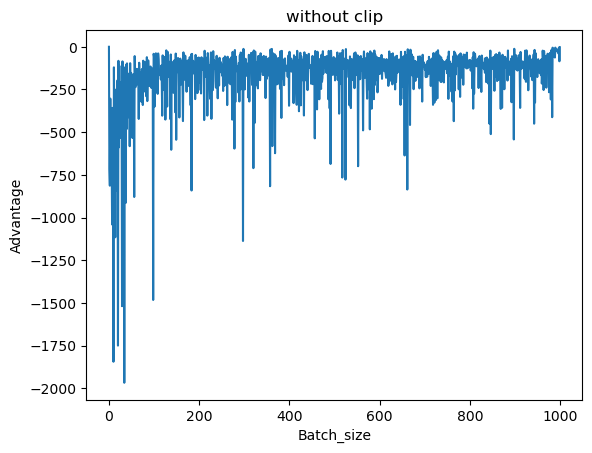

In [13]:
plt.plot((c2.detach().numpy()))
plt.xlabel('Batch_size')
plt.ylabel('Advantage')
plt.title('without clip')
plt.show()